* [출처 : A study on Regression applied to the Ames dataset ](https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset)
* RF, 앙상블, xgboost 같은 기법을 사용하지 않고 선형회귀만을 사용

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('ggplot')

In [2]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
train = pd.read_csv("data/train.csv")
train.shape

(1460, 81)

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [5]:
# 중복된 Id 값이 있는지 확인
idsUnique = len(set(train.Id))
idsTotal = train.shape[0]
idsDupli = idsTotal - idsUnique
print('중복된 Id 수: ' ,str(idsDupli))
print('전체 Id 수: ' ,str(idsTotal))

# Id 컬럼을 삭제한다.
train.drop("Id", axis = 1, inplace = True)

중복된 Id 수:  0
전체 Id 수:  1460


# Preprocessing
## 전처리
* Ames, Iowa: Alternative to the Boston Housing Data as an
End of Semester Regression Project
* http://jse.amstat.org/v19n3/decock.pdf

Text(0,0.5,'Sale Price')

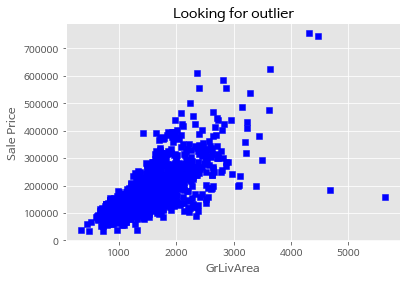

In [6]:
# 아웃라이어 데이터 보기 
plt.scatter(train.GrLivArea, train.SalePrice, 
            c='blue', marker='s')
plt.title('Looking for outlier')
plt.xlabel('GrLivArea')
plt.ylabel('Sale Price')

In [7]:
# 4000 을 넘는 데이터 중에 크기에 비해 저렴하게 거래 된 데이터가 있다.
# 아웃라이어 데이터는 제거한다.
train = train[train.GrLivArea < 4000]
train.shape

(1456, 80)

In [8]:
# 비싼집이든, 싼집이든 결과에 같은 영향을 미치도록 로그변환을 해준다. 
train.SalePrice =  np.log1p(train.SalePrice)
y = train.SalePrice

## 결측치
* NA값은 대부분 없는 것을 의미 하기 때문에 0, None, No 등 다른 row에 있는 값들과 맞춰준다.

In [9]:
fillna_0 = ['BedroomAbvGr', 
            'BsmtFullBath', 'BsmtHalfBath', 
            'BsmtUnfSF', 'EnclosedPorch', 
            'GarageArea', 'GarageCars', 'HalfBath',
            'KitchenAbvGr', 'LotFrontage',
            'MasVnrArea', 'OpenPorchSF',
            'PoolArea', 'ScreenPorch',
            'TotRmsAbvGrd', 'WoodDeckSF'
           ]
train[fillna_0].isnull().sum()

BedroomAbvGr       0
BsmtFullBath       0
BsmtHalfBath       0
BsmtUnfSF          0
EnclosedPorch      0
GarageArea         0
GarageCars         0
HalfBath           0
KitchenAbvGr       0
LotFrontage      259
MasVnrArea         8
OpenPorchSF        0
PoolArea           0
ScreenPorch        0
TotRmsAbvGrd       0
WoodDeckSF         0
dtype: int64

In [10]:
# 중복되는 항목이 없는지 확인한다.
print(len(fillna_0))
print(len(set(fillna_0)))

16
16


In [11]:
for fill_col in fillna_0:
    train[fill_col] = train[fill_col].fillna(0)

In [12]:
train[fillna_0].isnull().sum()

BedroomAbvGr     0
BsmtFullBath     0
BsmtHalfBath     0
BsmtUnfSF        0
EnclosedPorch    0
GarageArea       0
GarageCars       0
HalfBath         0
KitchenAbvGr     0
LotFrontage      0
MasVnrArea       0
OpenPorchSF      0
PoolArea         0
ScreenPorch      0
TotRmsAbvGrd     0
WoodDeckSF       0
dtype: int64

In [13]:
fillna_none = ['Alley', 'MasVnrType']
train[fillna_none].isnull().sum()

Alley         1365
MasVnrType       8
dtype: int64

In [14]:
for fill_col in fillna_none:
    train[fill_col] = train[fill_col].fillna(0)
    
train[fillna_none].isnull().sum()

Alley         0
MasVnrType    0
dtype: int64

In [15]:
fillna_no =  ['BsmtQual', 'BsmtCond', 
              'BsmtExposure', 'BsmtFinType1', 
              'BsmtFinType2', 'FireplaceQu', 
              'GarageType', 'GarageFinish', 
              'GarageQual', 'GarageCond', 
              'MiscFeature', 'PoolQC']

train[fillna_no].isnull().sum()

BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
FireplaceQu      690
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
MiscFeature     1402
PoolQC          1451
dtype: int64

In [16]:
for fill_col in fillna_no:
    train[fill_col] = train[fill_col].fillna(0)
    
train[fillna_no].isnull().sum()

BsmtQual        0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
FireplaceQu     0
GarageType      0
GarageFinish    0
GarageQual      0
GarageCond      0
MiscFeature     0
PoolQC          0
dtype: int64